In [5]:
# Setup Python path to import from src directory
import sys
from pathlib import Path

# Add the project root to Python path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

print(f"Added to Python path: {project_root}")
print("Ready to import from src module!")

Added to Python path: /Users/soufianeelhidaoui/Projects/statarb
Ready to import from src module!


# StatArb Exploration Notebook
Sélectionne des paires, trace spread & z-score avec la structure mise à jour.

In [8]:
from pathlib import Path
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone
import os

# Updated imports aligned with run_report.py
from src.config import load_params
from src.universe import load_universe
from src.data import ensure_universe, get_price_series, _root_dir_for_source
from src.pairs import all_pairs_from_universe, score_pairs
from src.stats import spread_series, zscore, ols_hedge_ratio
from src.decisions import decide_pair
from src.profile import merged_risk

# Change to project root directory so relative paths work
project_root = Path().absolute().parent
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

# Load config (now works with default relative path)
params = load_params()
source = params.get("data", {}).get("source", "yahoo").lower()
mode = params.get("trading", {}).get("mode", "paper").lower()

print(f"Source: {source}, Mode: {mode}")

# Load universe using the proper function
tickers = load_universe()
print(f"Universe: {tickers}")

# Ensure data is available
ensure_universe(params, tickers)

# Get correct root directory based on source
root_dir = _root_dir_for_source(params)
print(f"Data directory: {root_dir}")

Working directory: /Users/soufianeelhidaoui/Projects/statarb
Source: ibkr, Mode: paper
Universe: ['SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLP', 'XLI', 'XLRE', 'XLU', 'XLB', 'XLC']
Data directory: data/eod/ETFs_ibkr


In [9]:
# Load price data using updated structure from run_report.py
def _coalesce_meta(dfpl: pl.DataFrame) -> pd.DataFrame:
    """Convert Polars DataFrame to pandas with proper price handling"""
    cols = ["date", "adj_close", "close"]
    if "is_ex_div" in dfpl.columns: 
        cols.append("is_ex_div")
    
    pdf = dfpl.select(cols).to_pandas()
    pdf["date"] = pd.to_datetime(pdf["date"])
    px = pdf["adj_close"].fillna(pdf["close"])
    
    out = pd.DataFrame({"px": px.values}, index=pdf["date"].values)
    if "is_ex_div" in pdf.columns: 
        out["is_ex_div"] = pdf["is_ex_div"].astype(bool).values
    return out

def _coalesce_close(meta: pd.DataFrame, name: str) -> pd.Series:
    """Extract close price series with proper name"""
    s = meta["px"].copy()
    s.name = name
    return s

# Load and process price data
meta, price_map = {}, {}
for i, t in enumerate(tickers, start=1):
    try:
        dfpl = get_price_series(root_dir, t).sort("date")
        m = _coalesce_meta(dfpl)
        meta[t] = m
        price_map[t] = pd.DataFrame({"close": m["px"]})
        print(f"[{i}/{len(tickers)}] {t}: {len(m)} records")
    except Exception as e:
        print(f"[{i}/{len(tickers)}] {t}: Failed - {e}")
        continue

print(f"\nLoaded {len(price_map)} tickers successfully")

[1/15] SPY: 7542 records
[2/15] QQQ: 6675 records
[3/15] DIA: 6959 records
[4/15] IWM: 6364 records
[5/15] XLK: 6725 records
[6/15] XLF: 6725 records
[7/15] XLE: 6725 records
[8/15] XLV: 6725 records
[9/15] XLY: 6725 records
[10/15] XLP: 6725 records
[11/15] XLI: 6724 records
[12/15] XLRE: 2501 records
[13/15] XLU: 6725 records
[14/15] XLB: 6725 records
[15/15] XLC: 1823 records

Loaded 15 tickers successfully
[12/15] XLRE: 2501 records
[13/15] XLU: 6725 records
[14/15] XLB: 6725 records
[15/15] XLC: 1823 records

Loaded 15 tickers successfully


In [10]:
# Score pairs using updated structure
pairs = all_pairs_from_universe(tickers)
lb = params.get("lookbacks", {})
corr_days = int(lb.get("corr_days", 120))
coint_days = int(lb.get("coint_days", 120))

print(f"Scoring {len(pairs)} pairs with lookbacks: corr={corr_days}, coint={coint_days}")
scored = score_pairs(price_map, pairs, corr_days, coint_days)

print(f"Scored {len(scored)} pairs")
print("\nTop 10 pairs by score:")
print(scored.sort_values("score", ascending=False).head(10)[["a", "b", "corr", "half_life", "pval", "score"]])

Scoring 105 pairs with lookbacks: corr=120, coint=120
Scored 105 pairs

Top 10 pairs by score:
     a    b      corr  half_life      pval     score
0  SPY  DIA  0.951968   4.219065  0.045163  0.906804
1  SPY  QQQ  0.984724   5.182257  0.094479  0.890245
2  QQQ  XLK  0.985283   4.315922  0.096470  0.888813
3  XLF  XLI  0.922299   3.638089  0.040873  0.881427
4  DIA  XLY  0.890056   5.014178  0.015719  0.874337
5  QQQ  DIA  0.908940   4.801125  0.060103  0.848838
6  XLI  XLB  0.878148   3.808697  0.030433  0.847715
7  QQQ  XLF  0.872947   3.554530  0.027289  0.845658
8  SPY  XLF  0.920659   4.269077  0.076158  0.844500
9  DIA  XLK  0.880593   3.882605  0.039269  0.841323
Scored 105 pairs

Top 10 pairs by score:
     a    b      corr  half_life      pval     score
0  SPY  DIA  0.951968   4.219065  0.045163  0.906804
1  SPY  QQQ  0.984724   5.182257  0.094479  0.890245
2  QQQ  XLK  0.985283   4.315922  0.096470  0.888813
3  XLF  XLI  0.922299   3.638089  0.040873  0.881427
4  DIA  XLY  0.8

In [11]:
# Select top pairs using updated selection logic
def _sel_thresholds(params: dict) -> dict:
    """Extract selection thresholds from params"""
    sel = params.get("selection", {})
    sf = params.get("stats_filters", {})
    return {
        "min_corr": float(sel.get("min_corr", sf.get("min_corr", 0.6))),
        "pval": float(sel.get("pval_coint", sf.get("coint_pval_max", 0.05))),
        "max_hl": float(sel.get("max_half_life_days", sf.get("half_life_max_days", 20.0))),
    }

def _select_pairs(scored: pd.DataFrame, params: dict, topk: int) -> pd.DataFrame:
    """Select top pairs based on criteria"""
    th = _sel_thresholds(params)
    
    # Apply filters
    flt = (scored["corr"] >= th["min_corr"]) & (scored["pval"] <= th["pval"])
    
    # Check for half-life column (multiple possible names)
    hl_col = None
    for c in ("half_life", "half_life_days", "hl"):
        if c in scored.columns:
            hl_col = c
            break
    
    if hl_col is not None:
        flt &= (scored[hl_col] <= th["max_hl"])
    
    return scored.loc[flt].sort_values("score", ascending=False).head(topk).copy()

# Select top candidates
topk = 10
top = _select_pairs(scored, params, topk)
print(f"\nSelected {len(top)} top pairs:")
print(top[["a", "b", "corr", "half_life", "pval", "score"]].round(4))


Selected 10 top pairs:
      a    b    corr  half_life    pval   score
0   SPY  DIA  0.9520     4.2191  0.0452  0.9068
3   XLF  XLI  0.9223     3.6381  0.0409  0.8814
4   DIA  XLY  0.8901     5.0142  0.0157  0.8743
6   XLI  XLB  0.8781     3.8087  0.0304  0.8477
7   QQQ  XLF  0.8729     3.5545  0.0273  0.8457
9   DIA  XLK  0.8806     3.8826  0.0393  0.8413
11  XLY  XLC  0.8623     3.2800  0.0272  0.8352
12  XLK  XLF  0.8424     3.3902  0.0079  0.8345
13  IWM  XLC  0.8240     2.2425  0.0023  0.8217
14  XLF  XLY  0.8436     3.3321  0.0314  0.8122


In [12]:
# Analyze the top pair with updated decision logic
if len(top) > 0:
    # Get the best pair
    best_row = top.iloc[0]
    a, b = str(best_row["a"]), str(best_row["b"])
    
    # Get price series
    ya = _coalesce_close(meta[a], a)
    xb = _coalesce_close(meta[b], b)
    
    # Calculate spread and z-score using original logic
    dfa = price_map[a]['close']
    dfb = price_map[b]['close']
    alpha, beta = ols_hedge_ratio(dfa, dfb)
    spr = spread_series(dfa, dfb, alpha, beta)
    
    zscore_days = params.get('lookbacks', {}).get('zscore_days', 60)
    z = zscore(spr, zscore_days)
    
    # Get decision using updated logic
    spy_series = price_map.get("SPY", pd.DataFrame({"close": pd.Series(dtype=float)}))["close"] if "SPY" in price_map else None
    decision = decide_pair(
        ya, xb, spy_series, params,
        meta_a={"df": meta[a].rename(columns={"px": "close"})},
        meta_b={"df": meta[b].rename(columns={"px": "close"})}
    )
    
    print(f"\n=== Analysis for {a}/{b} ===")
    print(f"Correlation: {best_row['corr']:.4f}")
    print(f"Half-life: {best_row['half_life']:.2f} days")
    print(f"P-value (cointegration): {best_row['pval']:.4f}")
    print(f"Hedge ratio (β): {beta:.4f}")
    print(f"Alpha: {alpha:.4f}")
    print(f"Score: {best_row['score']:.4f}")
    
    print(f"\n=== Decision ===")
    print(f"Verdict: {decision.get('verdict', 'N/A')}")
    print(f"Action: {decision.get('action', 'N/A')}")
    print(f"Reason: {decision.get('reason', 'N/A')}")
    print(f"Current Z-score: {decision.get('z_last', 'N/A')}")
    
else:
    print("No pairs selected!")


=== Analysis for SPY/DIA ===
Correlation: 0.9520
Half-life: 4.22 days
P-value (cointegration): 0.0452
Hedge ratio (β): 1.3140
Alpha: -5.2039
Score: 0.9068

=== Decision ===
Verdict: HOLD
Action: None
Reason: No cointegration
Current Z-score: nan


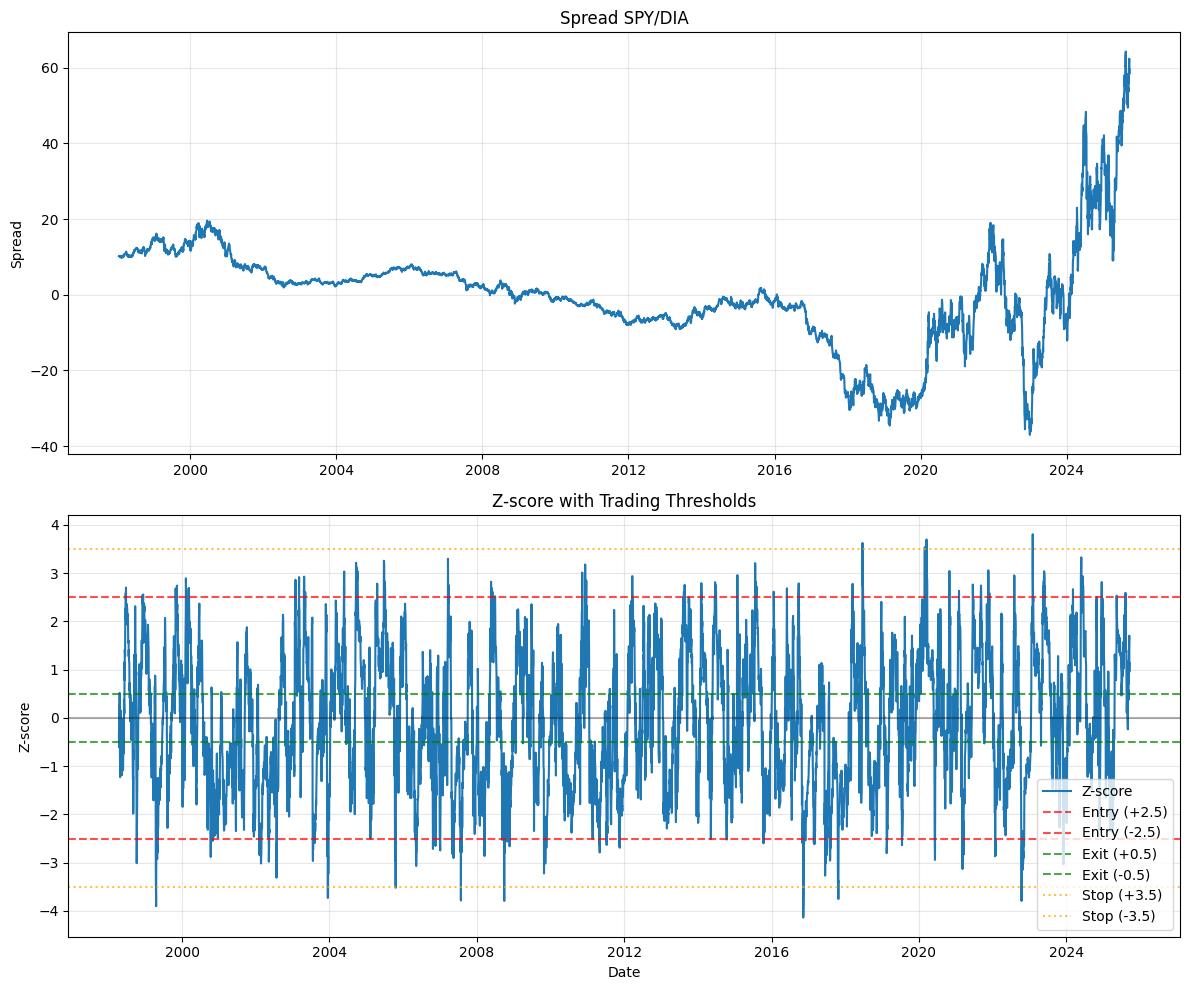


Potential entry signals (|z| >= 2.5): 332
Current z-score: 1.14
⏳ Monitoring zone

Spread statistics:
Mean: -0.00
Std: 13.48
Min: -37.02
Max: 64.28


In [13]:
# Plot spread and z-score with thresholds
if len(top) > 0 and 'spr' in locals() and 'z' in locals():
    # Get threshold parameters
    thresholds = params.get('thresholds', {})
    entry_z = thresholds.get('entry_z', 2.0)
    exit_z = thresholds.get('exit_z', 0.5)
    stop_z = thresholds.get('stop_z', 3.0)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot spread
    ax1.plot(spr.index, spr.values)
    ax1.set_title(f'Spread {a}/{b}')
    ax1.set_ylabel('Spread')
    ax1.grid(True, alpha=0.3)
    
    # Plot z-score with thresholds
    ax2.plot(z.index, z.values, label='Z-score')
    ax2.axhline(entry_z, color='red', linestyle='--', alpha=0.7, label=f'Entry (+{entry_z})')
    ax2.axhline(-entry_z, color='red', linestyle='--', alpha=0.7, label=f'Entry (-{entry_z})')
    ax2.axhline(exit_z, color='green', linestyle='--', alpha=0.7, label=f'Exit (+{exit_z})')
    ax2.axhline(-exit_z, color='green', linestyle='--', alpha=0.7, label=f'Exit (-{exit_z})')
    ax2.axhline(stop_z, color='orange', linestyle=':', alpha=0.7, label=f'Stop (+{stop_z})')
    ax2.axhline(-stop_z, color='orange', linestyle=':', alpha=0.7, label=f'Stop (-{stop_z})')
    ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
    
    ax2.set_title('Z-score with Trading Thresholds')
    ax2.set_ylabel('Z-score')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Count potential signals
    entry_signals = (abs(z) >= entry_z).sum()
    print(f"\nPotential entry signals (|z| >= {entry_z}): {entry_signals}")
    
    # Current z-score status
    current_z = z.iloc[-1] if not z.empty else 0
    print(f"Current z-score: {current_z:.2f}")
    
    if abs(current_z) >= entry_z:
        print("🔥 SIGNAL: Entry threshold reached!")
    elif abs(current_z) <= exit_z:
        print("✅ No position signal")
    else:
        print("⏳ Monitoring zone")
    
    # Spread statistics
    print(f"\nSpread statistics:")
    print(f"Mean: {spr.mean():.2f}")
    print(f"Std: {spr.std():.2f}")
    print(f"Min: {spr.min():.2f}")
    print(f"Max: {spr.max():.2f}")
else:
    print("No data available for plotting")

In [15]:
# Show risk and position sizing information
risk = merged_risk(params)
print("\n=== Risk Parameters ===")
print(f"Capital: ${risk.get('capital', 0):,.0f}")
print(f"Per trade %: {(risk.get('per_trade_pct', 0) or 0)*100:.2f}%")
print(f"Notional per trade: ${risk.get('notional_per_trade', 0):,.0f}")
print(f"Max positions: {risk.get('max_positions', 0)}")

# Calculate position sizes for the top pair if available
if len(top) > 0 and 'a' in locals() and 'b' in locals() and a in meta and b in meta:
    pa = float(meta[a]["px"].iloc[-1])
    pb = float(meta[b]["px"].iloc[-1])
    
    notional = float(risk.get("notional_per_trade", 0.0) or 0.0)
    if notional <= 0 and float(risk.get("per_trade_pct", 0.0) or 0.0) > 0:
        notional = float(risk.get("capital", 0.0) or 0.0) * float(risk.get("per_trade_pct", 0.0) or 0.0)
    
    qa = int(max(0, np.floor((notional/2.0)/max(pa, 1e-9))))
    qb = int(max(0, np.floor((notional/2.0)/max(pb, 1e-9))))
    
    print(f"\n=== Position Sizing for {a}/{b} ===")
    print(f"Price {a}: ${pa:.2f}")
    print(f"Price {b}: ${pb:.2f}")
    print(f"Notional: ${notional:,.0f}")
    print(f"Quantity {a}: {qa} shares (${qa*pa:,.0f})")
    print(f"Quantity {b}: {qb} shares (${qb*pb:,.0f})")
    print(f"Total position: ${qa*pa + qb*pb:,.0f}")
else:
    print("No position sizing available - missing data")


=== Risk Parameters ===
Capital: $3,000
Per trade %: 0.00%
Notional per trade: $500
Max positions: 0

=== Position Sizing for SPY/DIA ===
Price SPY: $662.26
Price DIA: $462.63
Notional: $500
Quantity SPY: 0 shares ($0)
Quantity DIA: 0 shares ($0)
Total position: $0
